# A Casual Analysis of Public Transportation in New York City

### Author: Nathaniel del Rosario, A17562063
[Rubric](file:///Users/nathaniel.delrosario/Downloads/Project_final_template.pdf)

### Introduction, Question(s), & Hypothesis

The New York City public transportation is arguably one of the best in North America, providing many different methods such as metro, ride share, and bike as the most common. However, it is not a perfect system, possessing its own set of shortcomings. For example, compared to Tokyo's public transportation infrastructure, NYC's system is not as expansive and under serves more areas compared to Tokyo. Considering such context, the question arises, "just how under served are parts of New York City in the scope of public transportation?" and furthermore, are there any effects in other domains due to these under served areas?

I hypothesize that there are in fact different factors whose effects that are correlated with some areas being under served specifically by the NYC metro such as these areas being more likely to experience more ride share and bike usage. Upon witnessing any correlation, the next question becomes “is there causation as well?” Answering such uncertainty is the goal of this project.

This question is important because it involves using population, ridership, geo-spatial, and tract data to help people not only understand their commute as well as identify potential causality between different events and transportation accessibility. On average people will spend at least an hour commuting to and from work and school, and this is a huge chunk of our day (1/16 if you get a full 8 hours of sleep!) Additionally, public transportation companies can benefit greatly from this analysis as they can modify their strategy to appeal more to commuters and plan where to expand service to those who are under served. Lastly, the average citizen would benefit from this information because it could convince them to take public transportation instead of contributing to the increasing problem of traffic congestion in major metropolitan areas.

### Related Work

Scarlett T. Jin, Hui Kong & Daniel Z. Sui (2019) Uber, Public Transit, and Urban Transportation Equity: A Case Study in New York City, The Professional Geographer, 71:2, 315-330, DOI: 10.1080/00330124.2018.1531038

distribution of Uber services is highly unequal, Correlation analysis 
shows that there tend to be fewer Uber pickups in low-income areas


Tang, J.; Gao, F.; Liu, F.; Zhang, W.; Qi, Y. Understanding Spatio-Temporal Characteristics of Urban Travel Demand Based on the Combination of GWR and GLM. Sustainability 2019, 11, 5525. https://doi.org/10.3390/su11195525


results suggest that most taxi trips are concentrated in a fraction of the geographical area. Variables including road density, subway accessibility, Uber vehicle, point of interests (POIs), commercial area, taxi-related accident and commuting time have significant effects on travel demand,

### Packages & Libraries

The packages and libraries used for our analysis are ArcGIS Online (including all ArcGIS features and analysis functions, Python, GeoPandas, shapely Point geometry)

### Data Sources

In [32]:
import pandas as pd
import numpy as np
import math
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point

import arcgis
from arcgis.gis import GIS
from arcgis import geometry
from arcgis.features import GeoAccessor, GeoSeriesAccessor, FeatureLayerCollection, FeatureSet, FeatureCollection, FeatureLayer
from arcgis.features.use_proximity import create_buffers
from IPython.display import display
import os

gis = GIS("https://ucsdonline.maps.arcgis.com/home/index.html", "dsc170wi24_", "")

In [74]:
m = gis.map('New York, NY')

In [75]:
# get transport feature layers
metro_stops_fl = gis.content.get('d52e004c3bda4397ae2145257ede1200')
rideshare_fl = gis.content.get('072e86100593482887a99aaaac8b2ada')
bike_lanes_fl = gis.content.get('8aff6fb97ef546679e97b1696bfbf052')
bike_lane_low_income_intersect_fl = gis.content.get('dc2e07a9af82464e94318c7dc71fc084')
bike_station_low_income_intersect_fl = gis.content.get('f0679d1e4ca44350abed2a48eecb7eb9')

# get income layers
low_income_binary_fl = gis.content.get('9bb695ac4b874286ab6645e4196f19bb')
income_dist_fl = gis.content.get('00847778292e466082388a18230f41ba')
gentrification_fl = gis.content.get('f8f47e4166d34862a6d340d8e2dcb55f')

m.add_layer(metro_stops_fl)
m.add_layer(rideshare_fl)
m.add_layer(bike_lanes_fl)
m

MapView(layout=Layout(height='400px', width='100%'))

In [76]:
# append to each feature service: /0/query?where=1%3D1&outFields=*&f=geojson
# Income: https://services1.arcgis.com/HmwnYiJTBZ4UkySc/arcgis/rest/services/NYCMedianIncomeDistributions_WFL1/FeatureServer/0/query?where=1%3D1&outFields=*&f=geojson
# The rest are uploaded to https://github.com/natdosan/causal-analysis-nyc-transit

In [77]:
# Load Data into GeoDataFames
bike_lane_low_income_intersections = gpd.read_file('data/bike_lane_low_income_intersections.json')
low_income_bike_station_intersections = gpd.read_file('data/low_income_bike_station_intersections.json')
uber_lyft_dropoffs = gpd.read_file('data/uber_lyft_dropoffs.json')
nyc_subway_stops = gpd.read_file('data/nyc_stations.json')
low_income_census = gpd.read_file('data/low_income_census.json')
nyc_gentrification = gpd.read_file('data/nyc_gentrification.json')
nyc_median_income = gpd.read_file('data/nyc_median_income.json')
nyc_boundaries = gpd.read_file('data/nyc_boundaries.geojson')

In [78]:
uber_lyft_dropoffs.head(1)

,OBJECTID_1,OBJECTID,Shape_Leng,zone,LocationID,borough,count_,DOLocationID,time_day,PULocationID,Shape__Area,Shape__Length,geometry
0,1,1,0.116357,Newark Airport,1,EWR,257837.0,1.0,Morning,NaN,7.903953e+07,37646.072282,"POLYGON ((-74.18445 40.69500, -74.18449 40.695..."


### Analysis

First we define public transportation as metro, bike, and uber. Walking and driving are non-public transporation. Keep this in mind as we go further with each analysis step

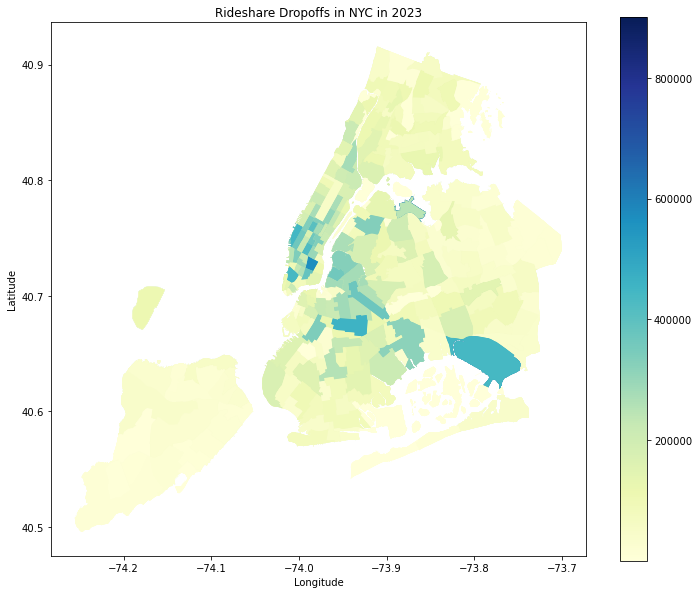

In [79]:
# Create Rideshare Choropleth
uber_lyft_dropoffs.plot(column='count_', cmap='YlGnBu', figsize=(12, 10), legend=True)
plt.title('Rideshare Dropoffs in NYC in 2023')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [80]:
# Look at Metro, Bike, Rideshare Intersections -> Create Buffers for Metro Stations, Bike Statinos

# Calculate buffer distance in relation to Manhattan blocks (used google for a rough estimate)
latitude_nyc = 40.7128  
longitude_nyc = -74.0060  
block_width_meters = 264 * 0.3048
block_length_meters = 900 * 0.3048
latitude_radians = math.radians(latitude_nyc)
longitude_radians = math.radians(longitude_nyc)

# Calculate the conversion factors for latitude and longitude
# I asked ChatGPT how to convert from meters to latitude / longitute degrees
latitude_conversion_factor = 111132.92 - 559.82 * math.cos(2 * latitude_radians) + 1.175 * math.cos(4 * latitude_radians) - 0.0023 * math.cos(6 * latitude_radians)
longitude_conversion_factor = 111412.84 * math.cos(latitude_radians) - 93.5 * math.cos(3 * latitude_radians)

# Convert block width and length to the same scale as latitude and longitude
block_width_degrees = block_width_meters / longitude_conversion_factor
block_length_degrees = block_length_meters / latitude_conversion_factor

In [81]:
for gdf in [bike_lane_low_income_intersections, low_income_bike_station_intersections, uber_lyft_dropoffs, nyc_subway_stops, low_income_census, nyc_gentrification, nyc_median_income]:
    print(f'CRS: {gdf.crs}')

CRS: epsg:4326
CRS: epsg:4326
CRS: epsg:4326
CRS: epsg:4326
CRS: epsg:4326
CRS: epsg:4326
CRS: epsg:4326


In [82]:
nyc_subway_stops.head(1)

,FID,stop_id,stop_name,stop_lat,stop_lon,trains,structure,stop_id2,GEOID,NAMELSAD,geometry
0,1,101,Van Cortlandt Park - 242 St,40.889248,-73.898583,1,Elevated,,36005,Bronx County,POINT (-73.89858 40.88926)


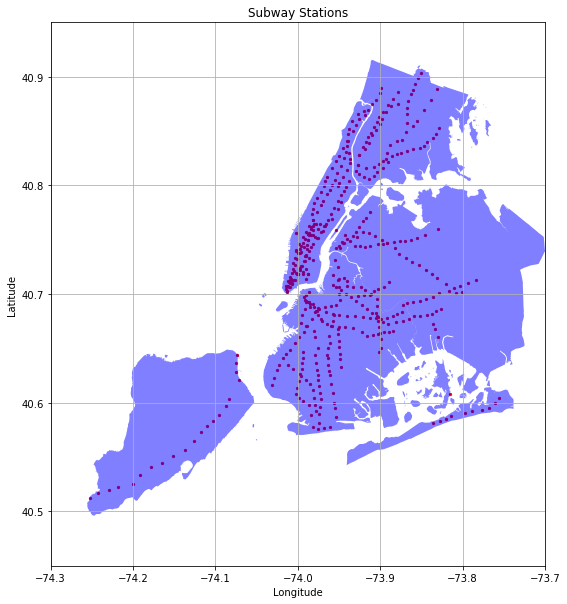

In [83]:
# Plot the subway stations
nyc_subway_stops.plot(marker='o', color='red', markersize=5, figsize=(10, 10))
plt.title('Subway Stations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
nyc_boundaries.plot(ax=plt.gca(), alpha=0.5, color='blue')
plt.xlim(-74.3, -73.7)
plt.ylim(40.45, 40.95)
plt.show()

/tmp/ipykernel_123/1966887895.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  nyc_subway_buffer = nyc_subway_stops.buffer(block_length_degrees)


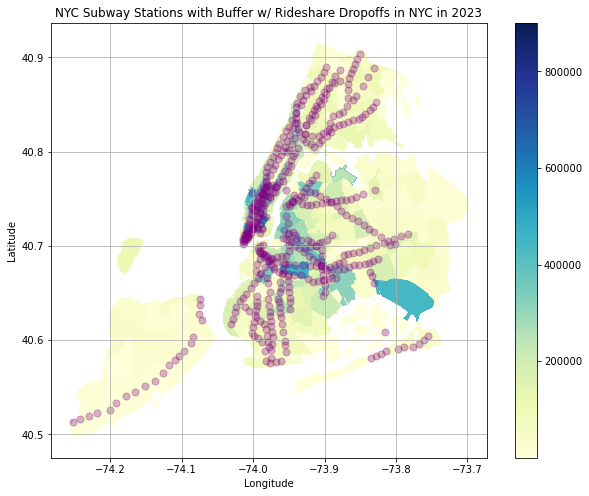

In [84]:
# Buffer around NYC subway stations
nyc_subway_buffer = nyc_subway_stops.buffer(block_length_degrees)  

# create map object: plot metro stop buffers
map1 = nyc_subway_buffer.plot(color='blue', alpha=0.3, figsize=(10, 8))
uber_lyft_dropoffs.plot(ax=map1, column='count_', cmap='YlGnBu', figsize=(10, 8), legend=True)
nyc_subway_stops.plot(ax=map1, marker='o', color='purple', markersize=50, alpha = .3)

plt.title('NYC Subway Stations with Buffer w/ Rideshare Dropoffs in NYC in 2023')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()

In [ ]:
# Look at income vs these intersections, (income vs metro, income vs bike, income vs rideshare)
# Do there apppear to be any correlation

In [ ]:
# Design Score / Metric for each Greater NYC adminstrative boundary 
# Low values point to lower income / lower accessibility / farther distance from metro, bike, uber buffers 

In [ ]:
# Finally, Choropleth of Score by Administrative Boundary

In [ ]:
# If time: regression to predict score

### Summary & Results

### Discussion

### Conclusions & Future Work